Implement the model in this paper: https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf
but character level LM
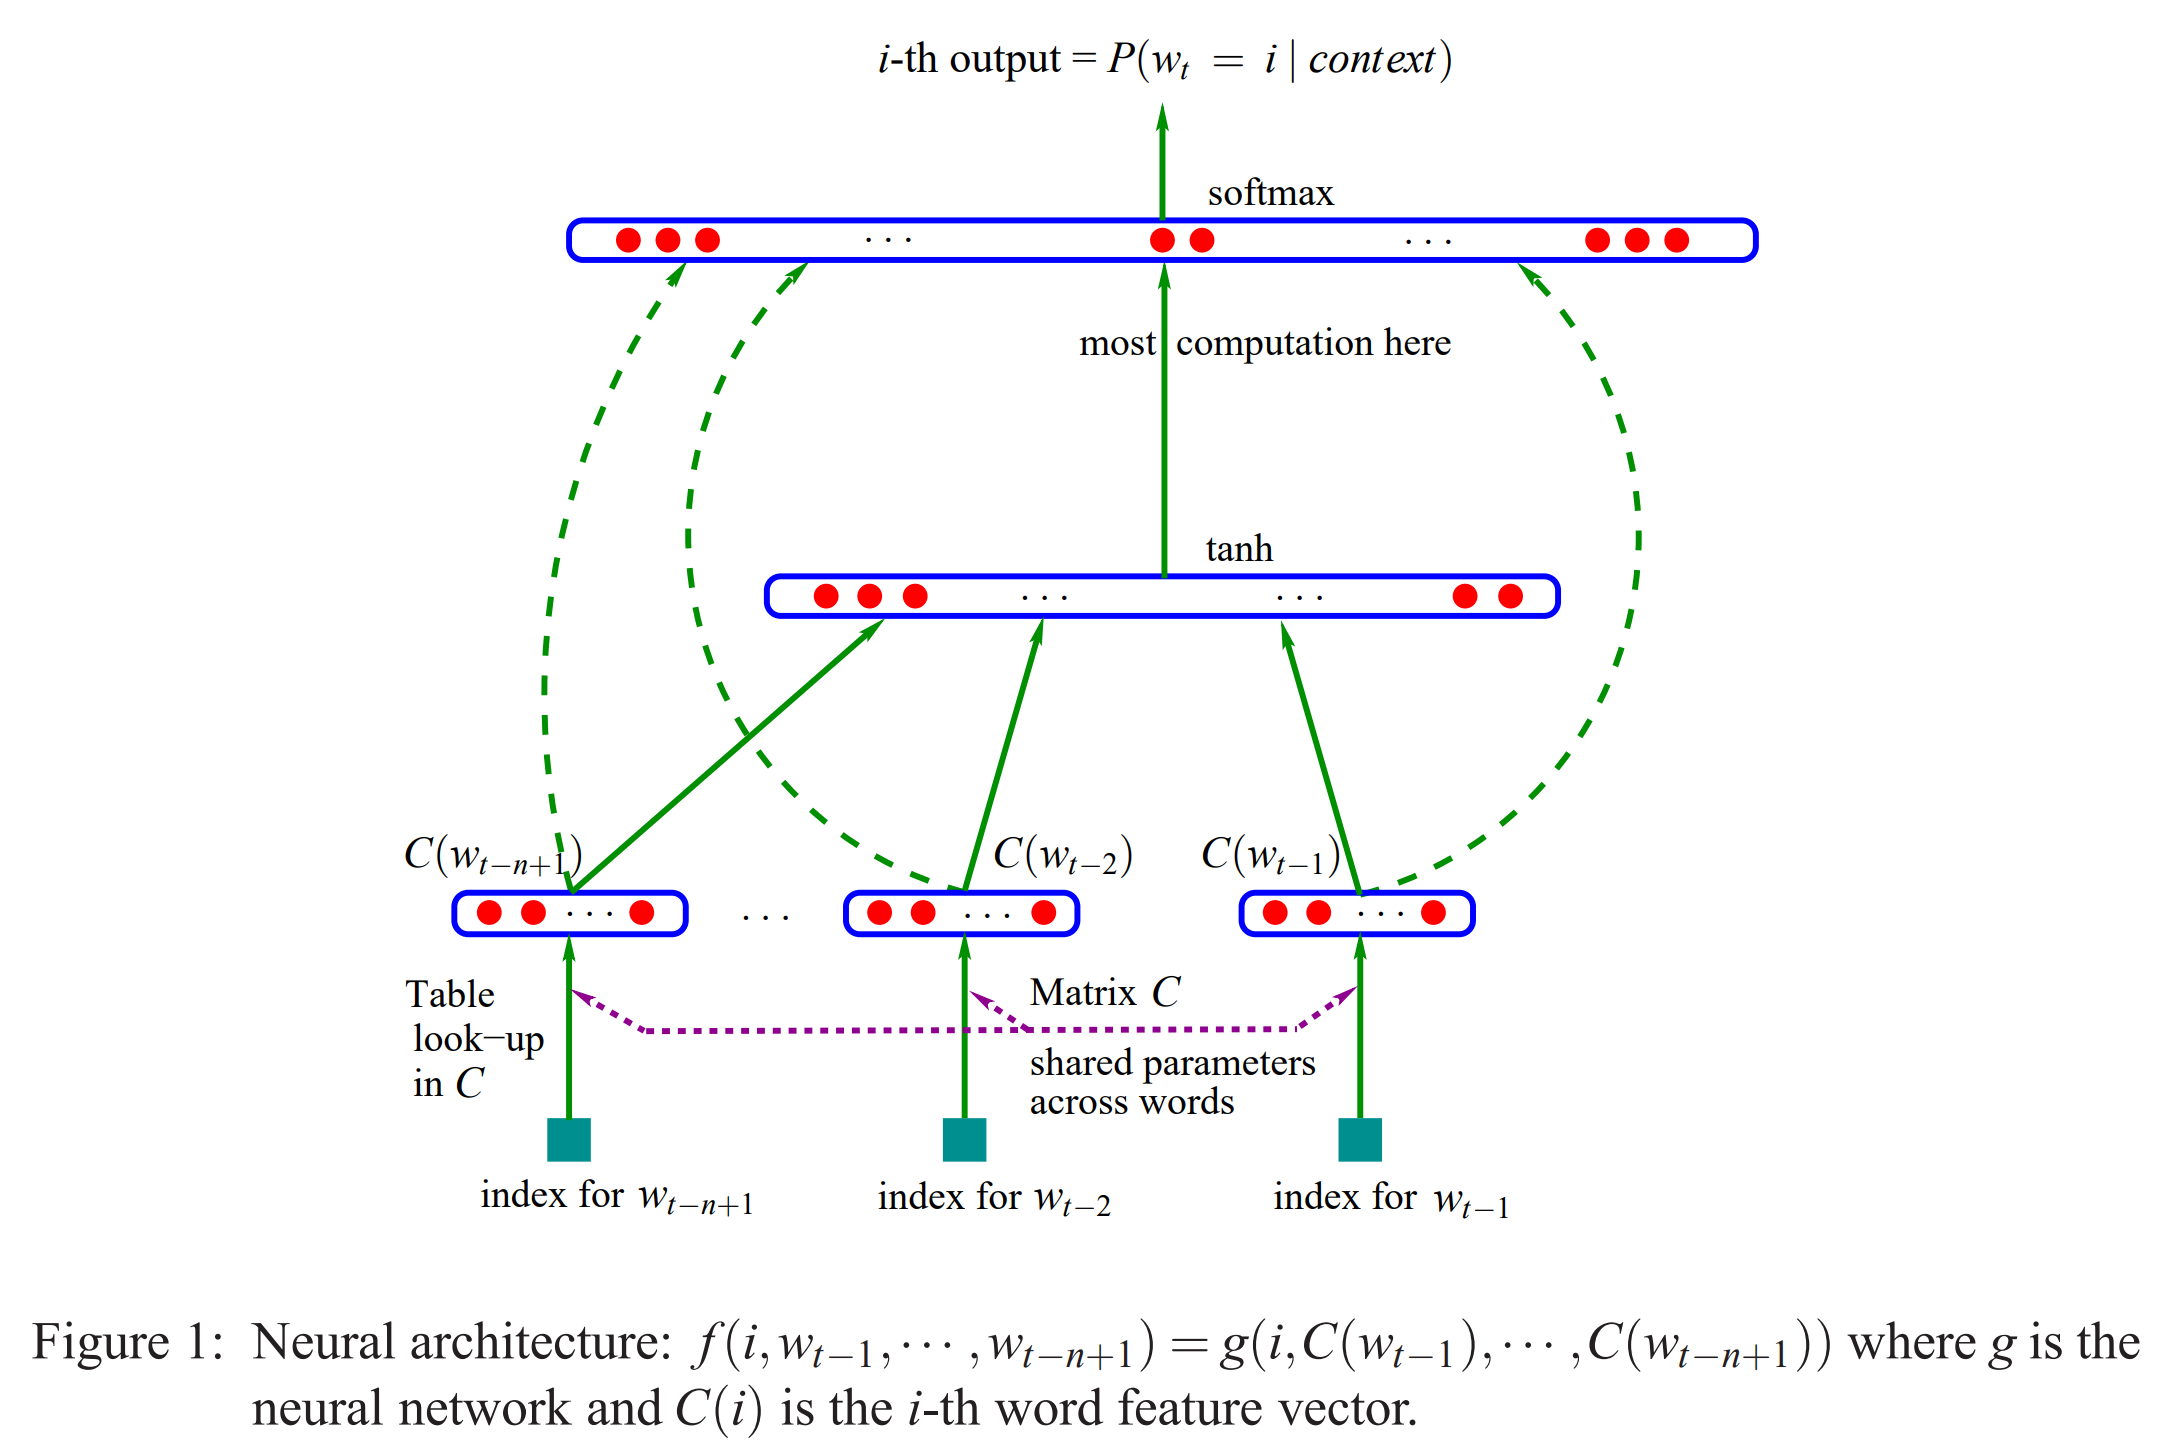

## Imports

In [1]:
import torch
import torch.nn.functional as F

## Build vocabulary and mappings

In [2]:
chr(97)

'a'

In [3]:
0 + ord('a')

97

In [4]:
vocab = [] # all poosible characters in the training corpus
itoc = {} # index to character mapping
ctoi = {} # character to index mapping
for i in range(26):
    c = chr(i+ord('a'))
    vocab.append(c)
    ctoi[c] = i+1
    itoc[i+1] = c

vocab.append('.')
itoc[0] = '.'
ctoi['.'] = 0

In [6]:
'|'.join(vocab)

'a|b|c|d|e|f|g|h|i|j|k|l|m|n|o|p|q|r|s|t|u|v|w|x|y|z|.'

## load data
- first 5 words only for sanity check

In [7]:
X = []
y = []
block_size = 3 # previous context size
with open('./names.txt', 'r') as f:
    for name in f.readlines()[:5]:
        context = [0]*block_size # initialize previous context of each word with '...', which translates to [0,0,0] indices in the vocab
        for c in name.strip() + '.': # append '.' to the end of name to capture ending sequences of each name
            label = ctoi[c] # vocab index of the current character in name
            print(''.join([itoc[i] for i in context]), "--->", c) # verify how data looks
            X.append(context)
            y.append(label)
            context = context[1:] + [label]

# in this case '.' is our start/stop special token

... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
... ---> a
..a ---> v
.av ---> a
ava ---> .
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [8]:
X = torch.tensor(X)
y = torch.tensor(y)
X.shape, y.shape

(torch.Size([32, 3]), torch.Size([32]))

## Build the NN
- start with the feature mapping C
- map the X[i] to C(X[i]) where X[i] represents "block_size" number of characters
- hidden layer with tanh activation function
- output layer with softmax
- negative log likelihood (NLL) loss

In [9]:
# initialize the feature vector mapping from vocab index to some low dimensional feature space (embedding)
# start with 2d space
feature_vector_dimensions = 2
vocab_size = len(vocab)
C = torch.randn((vocab_size, feature_vector_dimensions)) # random features drawn from normal distribution
C.shape

torch.Size([27, 2])

## Tensor tutorials

### tensor indexing

In [10]:
# tensor indexing
C[0] # picks the 1st row (or 1st element (which is vector here) along 1st the axis (axis 0))

tensor([-0.4561,  0.2421])

In [11]:
C[0, 1] # picks the 2nd column of 1st row 

tensor(0.2421)

In [12]:
C[[0,1]] # picks the 1st and 2nd row

tensor([[-0.4561,  0.2421],
        [ 1.6808,  0.0509]])

In [13]:
C[torch.tensor([0,1])] # same as above tensor can be passed

tensor([[-0.4561,  0.2421],
        [ 1.6808,  0.0509]])

In [14]:
C[:,0] # picks 1st column - take all 1st column elements from each row

tensor([-4.5614e-01,  1.6808e+00, -8.4414e-01, -5.5327e-01,  1.2979e+00,
        -2.0629e-01, -1.8999e+00,  5.8185e-01,  3.8734e-01, -1.9543e-03,
         4.0426e-01,  9.4857e-01, -1.1045e+00, -1.5079e+00, -1.3025e+00,
         1.4829e-01, -1.2166e-01, -1.5543e+00,  2.9527e-02,  4.7115e-02,
        -1.1848e+00,  1.5796e-01, -1.5987e+00, -3.0386e+00,  1.3051e+00,
         1.1391e+00, -6.1326e-01])

In [15]:
C[1,:] # picks 2nd row - take all 2nd row elements from each column
# same as C[1]

tensor([1.6808, 0.0509])

### tensor concat, unbind and view

In [16]:
# embed the first example
emb = C[X[0]]
emb, emb.shape

(tensor([[-0.4561,  0.2421],
         [-0.4561,  0.2421],
         [-0.4561,  0.2421]]),
 torch.Size([3, 2]))

In [17]:
# embed all examples [mini batch of 32 here is the entire training set]
emb = C[X]
emb.shape # 32 training examples, 3 tokens (chars here) as input, embedding dimension = 2

torch.Size([32, 3, 2])

- next (hidden) layer in NN would take these embeddings as input
- Now all layers in Multi-Layer Perceptron consist of a stack of neurons with 1D tensors as input and output
- currently our input is 2D with size (block_size, embed_dimension) for each of the 32 training examples
- flatten them into 1D tensor of size block_size * embed_dimension
- the input is essentially 3 embeddings placed side-by-side as a single 1D input layer [see diagram in 1st cell]

In [18]:
emb[:,0,:].shape # picks the first token embedding for all the examples

torch.Size([32, 2])

In [19]:
# concat the 3 tensors corresponding to 3 tokens horizontally into axis 1
input = torch.concat([emb[:,0,:], emb[:,1,:], emb[:,2,:]], dim = 1)
input.shape

torch.Size([32, 6])

- the above technique isn't robust to changes in block_size
- generalize the concatenation using unbind

In [20]:
# unbind literally unbinds the tensor along a particular dimension and gives N individual tensors, where N is size of that dimension
unb = torch.unbind(emb, dim = 1)
len(unb), unb[0].shape, unb[1].shape, unb[2].shape #, ... unb[N-1].shape

(3, torch.Size([32, 2]), torch.Size([32, 2]), torch.Size([32, 2]))

In [21]:
# now we can concat in a robust way - non-dependance on block_size
input = torch.concat(torch.unbind(emb, dim = 1), dim = 1)
input.shape

torch.Size([32, 6])

- above technique is still inefficent as both unbind and concat create new tensors from input tensors consuming memory
- hence, use tensor view operation to change the structure of existing tensor
- view rearranges the tensor elements by utilizing storage locations [read http://blog.ezyang.com/2019/05/pytorch-internals/]

In [22]:
emb.view(32, 6).shape # explicit setting

torch.Size([32, 6])

In [23]:
emb.view(32, -1).shape # -1 implies figure it out yourself, PyTorch implicitly derives -1 given the other dimensions

torch.Size([32, 6])

In [24]:
emb.view(-1, 2).shape

torch.Size([96, 2])

In [25]:
emb.view(1, -1).shape

torch.Size([1, 192])

In [26]:
print("View shape: ", emb.view(-1, block_size*feature_vector_dimensions).shape)
print("Original shape is maintained: ", emb.shape)

View shape:  torch.Size([32, 6])
Original shape is maintained:  torch.Size([32, 3, 2])


### implement first hidden layer using view operation

In [46]:
# intialize hyperparameter hidden_layer_size and parameters weights and bias
hidden_layer_size = 100
W1 = torch.randn((block_size*feature_vector_dimensions, hidden_layer_size))
b1 = torch.randn((hidden_layer_size))
W1.shape, b1.shape

(torch.Size([6, 100]), torch.Size([100]))

- here input*weight_matrix would give (32, 100) tensor and b1 is (100)
- broadcasting rules work as follows:
--> 32, 100
--> 1, 100
- rightmost dimensions are matched and replicated along all remaining (left) dimensions
- hence works here as we want the bias to be added to all the examples
- always be careful while broadcasting!!

In [47]:
z1 = emb.view(-1, block_size*feature_vector_dimensions) @ W1 + b1 # hidden layer outputs
ha = torch.tanh(z1) # hidden layer activations
z1.shape, ha.shape

(torch.Size([32, 100]), torch.Size([32, 100]))

### implement output layer

In [48]:
output_layer_size = vocab_size # as we want a probability distribution over the vocabulary
W2 = torch.randn((ha.shape[-1], output_layer_size))
b2 = torch.randn((output_layer_size))
z2 = ha @ W2 + b2 # logits
probs = torch.softmax(z2, dim=1)
probs.shape

torch.Size([32, 27])

In [49]:
probs[0] # probability distribution over vocabulary for 1st example, i.e., 
# likelihood of each token in vocabulary coming next in the sequence of block_size [previous 3 words here]

tensor([6.4085e-10, 8.9311e-09, 2.0020e-09, 3.1357e-07, 9.1802e-13, 5.5343e-13,
        5.7957e-13, 2.9670e-13, 3.8436e-09, 5.0517e-08, 9.9992e-01, 1.8426e-18,
        4.2049e-12, 6.4722e-09, 6.9118e-06, 2.7666e-08, 1.1530e-13, 4.7828e-10,
        6.7968e-05, 4.8592e-07, 6.7847e-10, 7.6962e-14, 1.3767e-08, 3.8786e-13,
        2.3762e-09, 4.7787e-12, 1.8197e-18])

In [50]:
# verify that it sums to one as its pdf
torch.sum(probs[0])

tensor(1.0000)

- now we have the prob distributions (over the vocab) for each input example (we have taken 32 here)
- these probabilities represent the likelihood of each token (char) in vocab conditioned over the previous block_size (3) tokens (characters here)
- these are predicted probs, we also have ground truths from our text corpus (emm ---> a)
- hence we pluck out the probability of the ground truth index (i.e., pluck out prob of 'a' index 1 for the above example)

In [51]:
probs[torch.arange(X.shape[0]), y] # refer torch tensor indexing/slicing above
# for each example we plucked out the probability for corresponding ground truth label y
# we want to maximize these probabilities/likelihoods to train the model to predict these more when conditioned on similar inputs

tensor([5.5343e-13, 4.2610e-11, 1.4551e-12, 6.3396e-11, 1.4041e-11, 2.7666e-08,
        7.9949e-10, 1.7016e-08, 1.5246e-10, 1.1636e-03, 8.5038e-12, 1.1576e-16,
        8.9311e-09, 2.3227e-06, 2.5428e-09, 6.7260e-16, 5.0517e-08, 9.6593e-09,
        6.5190e-09, 1.0460e-09, 1.2593e-12, 6.3639e-09, 3.6008e-10, 2.5301e-12,
        1.5517e-15, 4.8592e-07, 2.4436e-11, 4.7535e-14, 1.1241e-03, 1.3047e-09,
        6.2119e-03, 1.1660e-18])

In [52]:
# maximizing likelihood is equivalent to maximizing log likelihood (since log is monotonic increasing function)
# as always take average log likelihood over minibatch of 'n' examples [average loss function]
# equivalent to minimizing average negative log likelihood (nll)
loss = -probs[torch.arange(X.shape[0]), y].log().mean()
loss

tensor(22.1475)

- we should never compute the loss this way as its highly inefficient! Why?
    - We are creating many intermediate tensors that take up memory
    - the backprop will need to go through all the operations softmax, log, mean
- instead we can use torch.cross_entropy
    - implemented for efficiency
    - uses fused kernels (??)
    - no intermediate memory
    - efficent backprop as gradient can be calculated in single step (derivative of this loss is well known)
    - instead of chain of grads for each individual operation above!
    - one more reason, a trick that torch uses while implementing to ensure sane numbers [refer below]

In [ ]:
# torch has inbuilt function for cross entropy loss that takes logits and ground truth labels to compute loss
F.cross_entropy(z2, target = y) # z2 are the logits

tensor(22.1475)

### floating point inaccuracies in exponentiation

In [60]:
a = torch.tensor([-5, 1, 0, 3])
counts = a.exp()
prob_dist = counts/counts.sum() # here default dim = 0 used as we have 1D input data
prob_dist # works well no problem

tensor([2.8298e-04, 1.1416e-01, 4.1998e-02, 8.4356e-01])

In [75]:
# lets try setting one of the numbers to be very small (big negative)
a = torch.tensor([-10000, 1, 0, 3])
counts = a.exp()
prob_dist = counts/counts.sum() # here default dim = 0 used as we have 1D input data
prob_dist # still works well # underflowing not an issue here as it would be set to 0

tensor([0.0000, 0.1142, 0.0420, 0.8438])

In [73]:
# try setting one of the number to be big positive number
a = torch.tensor([-5, 1, 0, 100])
counts = a.exp()
prob_dist = counts/counts.sum() # here default dim = 0 used as we have 1D input data
prob_dist # fails!! # overflowing an issue as the number is set to float('inf')

tensor([0., 0., 0., nan])

this happens because of overflowing floating point representation
- e^100 >> max(fp32)

In [74]:
counts # has an floating inf

tensor([0.0067, 2.7183, 1.0000,    inf])

The Solution?!
- softmax is shift invariant
- say we shift all the logits by 'h'
- shifted_counts = [e^(x1+h), e^(x2+h), ...] => shifted_counts = e^h * original_counts
- shifted_total_counts = (e^(x1+h) + e^(x2+h) + ... ) => shifted_total_counts = e^h * (original_total_counts)
- shifted_softmax = shifted_counts / shifted_total_counts = original_softmax = original_counts/original_total_counts
- leverage this to solve the issue

In [76]:
# try shifting by negative of max element (100 here)
a = torch.tensor([-5, 1, 0, 100]) - 100
counts = a.exp()
prob_dist = counts/counts.sum() # here default dim = 0 used as we have 1D input data
prob_dist # works now!!

tensor([0.0000e+00, 1.0089e-43, 3.7835e-44, 1.0000e+00])

## Implementing forward and backward passes with above things in mind

In [ ]:
# forward pass
emb = C[X] # (number_of_examples, block_size/num input tokens, embedding_dimension)
h = torch.tanh(emb.view(-1, 3*feature_vector_dimensions) @ W1 + b1) # z = (W1*X + b1), a = g(z) g = tanh (activation) -> dim(number_of_examples, hidden_layer_size)
logits = h @ W2 + b2 # (hidden_layer_size, vocab_size)
loss = F.cross_entropy(logits, y)
loss

tensor(17.7697, grad_fn=<NllLossBackward0>)

In [ ]:
learning_rate = 0.1

In [ ]:
# ERROR!!
# need to explicitly specify that tensor requires_grad, so torch allocates memory for it!
for p in parameters:
    p.requires_grad = True

In [ ]:
# forward pass
emb = C[X] # (number_of_examples, block_size/num input tokens, embedding_dimension)
h = torch.tanh(emb.view(-1, 3*feature_vector_dimensions) @ W1 + b1) # z = (W1*X + b1), a = g(z) g = tanh (activation) -> dim(number_of_examples, hidden_layer_size)
logits = h @ W2 + b2 # (hidden_layer_size, vocab_size)
loss = F.cross_entropy(logits, y)
loss

tensor(13.6564, grad_fn=<NllLossBackward0>)

In [ ]:
# backward pass
# FIRST SET THE GRADS to ZERO!! In every pass
for p in parameters:
    p.grad = None
loss.backward()
# update params
for p in parameters:
    p.data += -learning_rate*p.grad

## Putting it all together
- now we are ready to write the forward and backward pass
- to help tracking, use fixed seed while generating random samples for parameter initialization

In [92]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, feature_vector_dimensions), generator = g)
W1 = torch.randn((block_size*feature_vector_dimensions, hidden_layer_size), generator=g)
b1 = torch.randn(hidden_layer_size, generator = g)
W2 = torch.randn((hidden_layer_size, output_layer_size), generator = g)
b2 = torch.randn(output_layer_size, generator=g)
parameters = [C, W1, b1, W2, b2]

In [93]:
parameters[0].nelement() # gives the number of elements in the 1st parameter 'C' here [embedding map]
total_parameters = sum([p.nelement() for p in parameters])
total_parameters

3481

In [96]:
for p in parameters:
    p.requires_grad = True

In [94]:
# hyperparameters
num_iterations = 10
learning_rate = 0.1

In [97]:
for _ in range(num_iterations):
    # forward pass
    emb = C[X] # (number_of_examples, block_size/num input tokens, embedding_dimension)
    h = torch.tanh(emb.view(-1, 3*feature_vector_dimensions) @ W1 + b1) # z = (W1*X + b1), a = g(z) g = tanh (activation) -> dim(number_of_examples, hidden_layer_size)
    logits = h @ W2 + b2 # (hidden_layer_size, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(loss.item())
    # backward pass
    # FIRST SET THE GRADS to ZERO!! In every pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update params
    for p in parameters:
        p.data += -learning_rate*p.grad

17.76971435546875
13.656400680541992
11.298768997192383
9.452457427978516
7.984262943267822
6.891321182250977
6.100014686584473
5.452036380767822
4.8981523513793945
4.4146647453308105


- running the above for larger num_iterations would result in very low loss
- because only 32 training examples were used for 3.5k parameter model! Overfitting
- lets collect all examples and run on entire training set

In [9]:
X = []
y = []
block_size = 3 # previous context size
with open('./names.txt', 'r') as f:
    for name in f.readlines():
        context = [0]*block_size # initialize previous context of each word with '...', which translates to [0,0,0] indices in the vocab
        for c in name.strip() + '.': # append '.' to the end of name to capture ending sequences of each name
            label = ctoi[c] # vocab index of the current character in name
            # print(''.join([itoc[i] for i in context]), "--->", c) # verify how data looks
            X.append(context)
            y.append(label)
            context = context[1:] + [label]

# in this case '.' is our start/stop special token

In [10]:
X = torch.tensor(X)
y = torch.tensor(y)
X.shape, y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [17]:
feature_vector_dimensions = 2
vocab_size = len(vocab)
hidden_layer_size = 100
output_layer_size = vocab_size
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, feature_vector_dimensions), generator = g)
W1 = torch.randn((block_size*feature_vector_dimensions, hidden_layer_size), generator=g)
b1 = torch.randn(hidden_layer_size, generator = g)
W2 = torch.randn((hidden_layer_size, output_layer_size), generator = g)
b2 = torch.randn(output_layer_size, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [18]:
num_iterations = 10
learning_rate = 0.1
import time
start = time.time()
for _ in range(num_iterations):
    # forward pass
    emb = C[X] # (number_of_examples, block_size/num input tokens, embedding_dimension)
    h = torch.tanh(emb.view(-1, 3*feature_vector_dimensions) @ W1 + b1) # z = (W1*X + b1), a = g(z) g = tanh (activation) -> dim(number_of_examples, hidden_layer_size)
    logits = h @ W2 + b2 # (hidden_layer_size, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(loss.item())
    # backward pass
    # FIRST SET THE GRADS to ZERO!! In every pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update params
    for p in parameters:
        p.data += -learning_rate*p.grad
end = time.time()

print(f"Time taken for {num_iterations} iterations: {end-start}s")

19.505229949951172
17.08449363708496
15.776531219482422
14.833340644836426
14.002603530883789
13.25325870513916
12.579917907714844
11.983101844787598
11.47049331665039
11.05185604095459
Time taken for 10 iterations: 6.295689582824707s


- the iterations are slow as we are running the forward/backward passes for entire dataset at once
- hence, use mini-batches of data for approx descent but faster iterations

#### take random samples

In [24]:
mini_batch_size = 32 # num examples to process in each iteration
# technique for random sampling from entire data each pass
torch.randint(0, 5, (mini_batch_size,)) # generates random ints between 0 and 4 inclusive
# and returns tensor of shape tuple: (mini_batch_size, )

tensor([2, 3, 2, 3, 4, 1, 4, 1, 1, 2, 4, 3, 2, 3, 3, 0, 3, 4, 2, 3, 1, 1, 2, 0,
        0, 3, 2, 2, 1, 3, 0, 0])

In [26]:
# we want to get random indices (0<=index<num_training_examples) of training data
ix = torch.randint(0, X.shape[0], (mini_batch_size,))
ix

tensor([200991,  64778, 102798,  28966,  46597,  62719,  40976, 195703,  10573,
        137620, 169524,  38038, 150263, 213270,  55924,  46991, 127416,  37564,
        201961, 122503, 161458,  86792,   4828,  79165, 225020, 211134,  56666,
        212592, 189138, 143807,  43390, 135005])

In [27]:
# take the random slice from training data
X[ix]

tensor([[11,  8,  1],
        [ 1, 12, 25],
        [ 0,  0,  0],
        [ 4,  9,  1],
        [ 1,  9, 22],
        [21, 12,  9],
        [14,  9,  5],
        [ 0,  0,  0],
        [ 0,  0, 13],
        [ 0,  0,  0],
        [ 0, 18, 25],
        [ 0, 18,  5],
        [ 4,  1, 24],
        [ 4,  5, 14],
        [ 1, 12,  5],
        [14,  1, 18],
        [ 0, 19,  1],
        [ 5, 14, 22],
        [13,  9, 17],
        [ 0,  0, 11],
        [ 4, 15, 14],
        [26,  1, 18],
        [ 1, 14, 25],
        [ 1, 18, 25],
        [18,  1,  9],
        [ 9,  4,  9],
        [ 0, 13,  5],
        [12, 12,  5],
        [ 0,  0, 12],
        [18,  1, 25],
        [13,  9,  3],
        [ 0,  3,  1]])

#### continue

In [29]:
num_iterations = 10
mini_batch_size = 32
learning_rate = 0.1
start = time.time()
for _ in range(num_iterations):
    # forward pass
    # sample mini_batch
    ix = torch.randint(0, X.shape[0], (mini_batch_size,))
    emb = C[X[ix]] # (mini_batch_size, block_size/num input tokens, embedding_dimension)
    h = torch.tanh(emb.view(-1, 3*feature_vector_dimensions) @ W1 + b1) # z = (W1*X + b1), a = g(z) g = tanh (activation) -> dim(number_of_examples, hidden_layer_size)
    logits = h @ W2 + b2 # (hidden_layer_size, vocab_size)
    loss = F.cross_entropy(logits, y[ix])
    print(loss.item())
    # backward pass
    # FIRST SET THE GRADS to ZERO!! In every pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update params
    for p in parameters:
        p.data += -learning_rate*p.grad
end = time.time()

print(f"Time taken for {num_iterations} iterations: {end-start}s")

10.68451976776123
9.23234748840332
11.438700675964355
10.185835838317871
10.253325462341309
10.380631446838379
9.897117614746094
9.645862579345703
11.10568904876709
9.86567211151123
Time taken for 10 iterations: 0.029500961303710938s


Superfast!!

Running for longer iterations

In [36]:
# run this same cell again and again to continue training from the end of previous 100 iterations
num_iterations = 100
for _ in range(num_iterations):
    # forward pass
    # sample mini_batch
    ix = torch.randint(0, X.shape[0], (mini_batch_size,))
    emb = C[X[ix]] # (mini_batch_size, block_size/num input tokens, embedding_dimension)
    h = torch.tanh(emb.view(-1, 3*feature_vector_dimensions) @ W1 + b1) # z = (W1*X + b1), a = g(z) g = tanh (activation) -> dim(number_of_examples, hidden_layer_size)
    logits = h @ W2 + b2 # (hidden_layer_size, vocab_size)
    loss = F.cross_entropy(logits, y[ix])
    # backward pass
    # FIRST SET THE GRADS to ZERO!! In every pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update params
    for p in parameters:
        p.data += -learning_rate*p.grad

print(loss.item()) # this loss represents the loss on latest mini_batch of data

2.4293735027313232


Loss in prev cell represents loss on last mini_batch. Let's check loss on entire data

In [37]:
emb = C[X] # (mini_batch_size, block_size/num input tokens, embedding_dimension)
h = torch.tanh(emb.view(-1, 3*feature_vector_dimensions) @ W1 + b1) # z = (W1*X + b1), a = g(z) g = tanh (activation) -> dim(number_of_examples, hidden_layer_size)
logits = h @ W2 + b2 # (hidden_layer_size, vocab_size)
loss_on_full_data = F.cross_entropy(logits, y)
loss_on_full_data

tensor(2.8193, grad_fn=<NllLossBackward0>)

## Experimenting with different learning rates
- if too low, slow training
- if too high, unstable and may not converge
- tuning to sweet spot is the key

#### too low

In [40]:
learning_rate = 0.001

feature_vector_dimensions = 2
vocab_size = len(vocab)
hidden_layer_size = 100
output_layer_size = vocab_size
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, feature_vector_dimensions), generator = g)
W1 = torch.randn((block_size*feature_vector_dimensions, hidden_layer_size), generator=g)
b1 = torch.randn(hidden_layer_size, generator = g)
W2 = torch.randn((hidden_layer_size, output_layer_size), generator = g)
b2 = torch.randn(output_layer_size, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [41]:
# run this same cell again and again to continue training from the end of previous 100 iterations
num_iterations = 10
for _ in range(num_iterations):
    # forward pass
    # sample mini_batch
    ix = torch.randint(0, X.shape[0], (mini_batch_size,))
    emb = C[X[ix]] # (mini_batch_size, block_size/num input tokens, embedding_dimension)
    h = torch.tanh(emb.view(-1, 3*feature_vector_dimensions) @ W1 + b1) # z = (W1*X + b1), a = g(z) g = tanh (activation) -> dim(number_of_examples, hidden_layer_size)
    logits = h @ W2 + b2 # (hidden_layer_size, vocab_size)
    loss = F.cross_entropy(logits, y[ix])
    print(loss.item())
    # backward pass
    # FIRST SET THE GRADS to ZERO!! In every pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update params
    for p in parameters:
        p.data += -learning_rate*p.grad

19.503883361816406
21.939844131469727
18.677762985229492
18.187538146972656
16.89202880859375
18.560283660888672
17.944658279418945
18.09351921081543
17.972753524780273
18.100404739379883


#### too high

In [42]:
learning_rate = 10

feature_vector_dimensions = 2
vocab_size = len(vocab)
hidden_layer_size = 100
output_layer_size = vocab_size
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, feature_vector_dimensions), generator = g)
W1 = torch.randn((block_size*feature_vector_dimensions, hidden_layer_size), generator=g)
b1 = torch.randn(hidden_layer_size, generator = g)
W2 = torch.randn((hidden_layer_size, output_layer_size), generator = g)
b2 = torch.randn(output_layer_size, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [43]:
# run this same cell again and again to continue training from the end of previous 100 iterations
num_iterations = 10
for _ in range(num_iterations):
    # forward pass
    # sample mini_batch
    ix = torch.randint(0, X.shape[0], (mini_batch_size,))
    emb = C[X[ix]] # (mini_batch_size, block_size/num input tokens, embedding_dimension)
    h = torch.tanh(emb.view(-1, 3*feature_vector_dimensions) @ W1 + b1) # z = (W1*X + b1), a = g(z) g = tanh (activation) -> dim(number_of_examples, hidden_layer_size)
    logits = h @ W2 + b2 # (hidden_layer_size, vocab_size)
    loss = F.cross_entropy(logits, y[ix])
    print(loss.item())
    # backward pass
    # FIRST SET THE GRADS to ZERO!! In every pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update params
    for p in parameters:
        p.data += -learning_rate*p.grad

22.050195693969727
33.31892776489258
43.625640869140625
48.18366622924805
84.59422302246094
75.12313079833984
65.34648132324219
80.38249206542969
70.55550384521484
69.94076538085938


#### choosing the right one

In [61]:
# define search space for learning rate
# lr_search_space = [0.001, 1]; we already have evidence 10 is too big
lrs = torch.linspace(-3, 0, 1000) # 1000 steps between -3 and 0 inclusive [represent exponents]
lre = 10**lrs # raise to 10 for rates between [0.001, 1]
lre

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

- schedule the learning rate to linearly increase from 0.001 to 1 in each iteration
- lets collect the losses at each iteration

In [62]:
# start from scratch again
feature_vector_dimensions = 2
vocab_size = len(vocab)
hidden_layer_size = 100
output_layer_size = vocab_size
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, feature_vector_dimensions), generator = g)
W1 = torch.randn((block_size*feature_vector_dimensions, hidden_layer_size), generator=g)
b1 = torch.randn(hidden_layer_size, generator = g)
W2 = torch.randn((hidden_layer_size, output_layer_size), generator = g)
b2 = torch.randn(output_layer_size, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [63]:
losses = [] # collect losses across iterations
num_iterations = 1000
for _ in range(num_iterations):
    # forward pass
    # sample mini_batch
    ix = torch.randint(0, X.shape[0], (mini_batch_size,))
    emb = C[X[ix]] # (mini_batch_size, block_size/num input tokens, embedding_dimension)
    h = torch.tanh(emb.view(-1, 3*feature_vector_dimensions) @ W1 + b1) # z = (W1*X + b1), a = g(z) g = tanh (activation) -> dim(number_of_examples, hidden_layer_size)
    logits = h @ W2 + b2 # (hidden_layer_size, vocab_size)
    loss = F.cross_entropy(logits, y[ix])
    losses.append(loss.item())
    # backward pass
    # FIRST SET THE GRADS to ZERO!! In every pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update params
    learning_rate = lre[i] # pick learning rate for current iteration
    for p in parameters:
        p.data += -learning_rate*p.grad

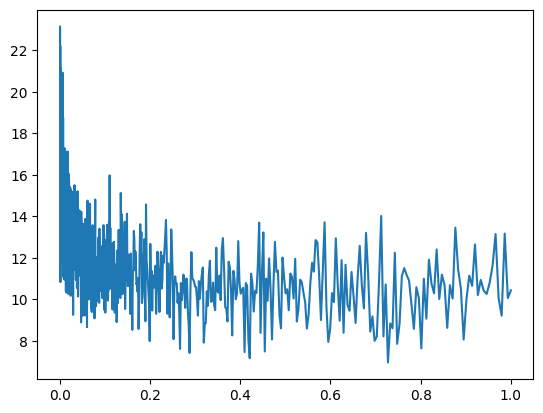

In [90]:
from matplotlib import pyplot as plt # to visualize the effect of learning rates
plt.plot(lre, losses)

Loss decreases till lr = 0.1 and then starts oscillating
choose 0.1 initially
- learning rate is decayed towards the end for decreased min loss search space
- this might further improve the loss

In [91]:
# start from scratch again
learning_rate = 0.1
feature_vector_dimensions = 2
vocab_size = len(vocab)
hidden_layer_size = 100
output_layer_size = vocab_size
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, feature_vector_dimensions), generator = g)
W1 = torch.randn((block_size*feature_vector_dimensions, hidden_layer_size), generator=g)
b1 = torch.randn(hidden_layer_size, generator = g)
W2 = torch.randn((hidden_layer_size, output_layer_size), generator = g)
b2 = torch.randn(output_layer_size, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [112]:
num_iterations = 10000
for _ in range(num_iterations):
    # forward pass
    # sample mini_batch
    ix = torch.randint(0, X.shape[0], (mini_batch_size,))
    emb = C[X[ix]] # (mini_batch_size, block_size/num input tokens, embedding_dimension)
    h = torch.tanh(emb.view(-1, 3*feature_vector_dimensions) @ W1 + b1) # z = (W1*X + b1), a = g(z) g = tanh (activation) -> dim(number_of_examples, hidden_layer_size)
    logits = h @ W2 + b2 # (hidden_layer_size, vocab_size)
    loss = F.cross_entropy(logits, y[ix])
    # backward pass
    # FIRST SET THE GRADS to ZERO!! In every pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update params
    for p in parameters:
        p.data += -learning_rate*p.grad

In [110]:
emb = C[X] # (mini_batch_size, block_size/num input tokens, embedding_dimension)
h = torch.tanh(emb.view(-1, 3*feature_vector_dimensions) @ W1 + b1) # z = (W1*X + b1), a = g(z) g = tanh (activation) -> dim(number_of_examples, hidden_layer_size)
logits = h @ W2 + b2 # (hidden_layer_size, vocab_size)
loss_on_full_data = F.cross_entropy(logits, y)
loss_on_full_data

tensor(2.3772, grad_fn=<NllLossBackward0>)

- we ran the above training for ~40k iterations
- loss achieved 2.38
- try reducing the learning rate to improve further

In [111]:
learning_rate = 0.01 # as we come close to the min, overshooting can happen, hence lower the gradient steps

In [113]:
emb = C[X] # (mini_batch_size, block_size/num input tokens, embedding_dimension)
h = torch.tanh(emb.view(-1, 3*feature_vector_dimensions) @ W1 + b1) # z = (W1*X + b1), a = g(z) g = tanh (activation) -> dim(number_of_examples, hidden_layer_size)
logits = h @ W2 + b2 # (hidden_layer_size, vocab_size)
loss_on_full_data = F.cross_entropy(logits, y)
loss_on_full_data

tensor(2.3058, grad_fn=<NllLossBackward0>)

- achieved min loss of 2.3 by further training with reduced learning rate!
- last time we achieved 2.33 loss with a trigram single layer NN
- does it mean current MLP model is better?? Not necessarily!
- we still need to validate this via validation/test set to check for overfitting

Standard practice
- train/val/test split
- if small data: bigger test/val splits
- if big data: smaller val splits work well enough to utilize bigger chunks for training

## Evaluating model
- train/dev/test split

In [118]:
def build_dataset(words):
    X = []
    y = []
    block_size = 3 # previous context size
    for name in words:
        context = [0]*block_size # initialize previous context of each word with '...', which translates to [0,0,0] indices in the vocab
        for c in name.strip() + '.': # append '.' to the end of name to capture ending sequences of each name
            label = ctoi[c] # vocab index of the current character in name
            X.append(context)
            y.append(label)
            context = context[1:] + [label]
    return torch.tensor(X), torch.tensor(y)

with open('./names.txt', 'r') as f:
    words = [w.strip() for w in f.readlines()]

train_size = int(len(words)*0.8)
dev_size = int(len(words)*0.9) - train_size
Xtr, ytr = build_dataset(words[:train_size])
Xdev, ydev = build_dataset(words[train_size:train_size + dev_size])
Xtest, ytest = build_dataset(words[train_size+dev_size:])

In [120]:
Xtr.shape, Xdev.shape, Xtest.shape

(torch.Size([182778, 3]), torch.Size([22633, 3]), torch.Size([22735, 3]))

In [129]:
# start from scratch again
feature_vector_dimensions = 2
vocab_size = len(vocab)
hidden_layer_size = 100
output_layer_size = vocab_size
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, feature_vector_dimensions), generator = g)
W1 = torch.randn((block_size*feature_vector_dimensions, hidden_layer_size), generator=g)
b1 = torch.randn(hidden_layer_size, generator = g)
W2 = torch.randn((hidden_layer_size, output_layer_size), generator = g)
b2 = torch.randn(output_layer_size, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [136]:
learning_rate = 0.01
num_iterations = 10000
for _ in range(num_iterations):
    # forward pass
    # sample mini_batch
    ix = torch.randint(0, Xtr.shape[0], (mini_batch_size,))
    emb = C[Xtr[ix]] # (mini_batch_size, block_size/num input tokens, embedding_dimension)
    h = torch.tanh(emb.view(-1, 3*feature_vector_dimensions) @ W1 + b1) # z = (W1*X + b1), a = g(z) g = tanh (activation) -> dim(number_of_examples, hidden_layer_size)
    logits = h @ W2 + b2 # (hidden_layer_size, vocab_size)
    loss = F.cross_entropy(logits, ytr[ix])
    # backward pass
    # FIRST SET THE GRADS to ZERO!! In every pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update params
    for p in parameters:
        p.data += -learning_rate*p.grad

In [137]:
# train loss
print(loss.item())

2.5220236778259277


In [138]:
# dev loss
emb = C[Xdev] # (mini_batch_size, block_size/num input tokens, embedding_dimension)
h = torch.tanh(emb.view(-1, 3*feature_vector_dimensions) @ W1 + b1) # z = (W1*X + b1), a = g(z) g = tanh (activation) -> dim(number_of_examples, hidden_layer_size)
logits = h @ W2 + b2 # (hidden_layer_size, vocab_size)
dev_loss = F.cross_entropy(logits, ydev)
dev_loss.item()

2.551999807357788

- both are equally high => can imply underfitting
- next we should try tuning the other hyperparameters -> hidden layer size, embedding dimensions etc.

## other hyperparameter tuning
- hidden layer size, input emb dimension

#### hidden layer size

In [141]:
# lets try increasing the hidden layer size
feature_vector_dimensions = 2
vocab_size = len(vocab)
hidden_layer_size = 300
output_layer_size = vocab_size
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, feature_vector_dimensions), generator = g)
W1 = torch.randn((block_size*feature_vector_dimensions, hidden_layer_size), generator=g)
b1 = torch.randn(hidden_layer_size, generator = g)
W2 = torch.randn((hidden_layer_size, output_layer_size), generator = g)
b2 = torch.randn(output_layer_size, generator=g)
parameters = [C, W1, b1, W2, b2]
num_params = sum([p.nelement() for p in parameters])
for p in parameters:
    p.requires_grad = True
print(f"Num Params: {num_params}")

Num Params: 10281


- more params means NN will take longer to learn

In [152]:
learning_rate = 0.01 # 1st 90k iterations withm 0.1
num_iterations = 30000 # this was run many times
for _ in range(num_iterations):
    # forward pass
    # sample mini_batch
    ix = torch.randint(0, Xtr.shape[0], (mini_batch_size,))
    emb = C[Xtr[ix]] # (mini_batch_size, block_size/num input tokens, embedding_dimension)
    h = torch.tanh(emb.view(-1, 3*feature_vector_dimensions) @ W1 + b1) # z = (W1*X + b1), a = g(z) g = tanh (activation) -> dim(number_of_examples, hidden_layer_size)
    logits = h @ W2 + b2 # (hidden_layer_size, vocab_size)
    loss = F.cross_entropy(logits, ytr[ix])
    # backward pass
    # FIRST SET THE GRADS to ZERO!! In every pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update params
    for p in parameters:
        p.data += -learning_rate*p.grad

In [153]:
print("Training loss: ", loss.item())

Training loss:  2.1822304725646973


In [154]:
# dev loss
emb = C[Xdev] # (mini_batch_size, block_size/num input tokens, embedding_dimension)
h = torch.tanh(emb.view(-1, 3*feature_vector_dimensions) @ W1 + b1) # z = (W1*X + b1), a = g(z) g = tanh (activation) -> dim(number_of_examples, hidden_layer_size)
logits = h @ W2 + b2 # (hidden_layer_size, vocab_size)
dev_loss = F.cross_entropy(logits, ydev)
print("Dev Loss: ", dev_loss.item())

Dev Loss:  2.474485158920288


In [ ]:
print("Training loss: ", loss.item())

Training loss:  2.1822304725646973


In [ ]:
# dev loss
emb = C[Xdev] # (mini_batch_size, block_size/num input tokens, embedding_dimension)
h = torch.tanh(emb.view(-1, 3*feature_vector_dimensions) @ W1 + b1) # z = (W1*X + b1), a = g(z) g = tanh (activation) -> dim(number_of_examples, hidden_layer_size)
logits = h @ W2 + b2 # (hidden_layer_size, vocab_size)
dev_loss = F.cross_entropy(logits, ydev)
print("Dev Loss: ", dev_loss.item())

Dev Loss:  2.474485158920288


- we have achieved an even lower loss of 2.18
- unable to generalize on dev set = 2.47
- let's try visualizing the embeddings to see if network has learnt anything about the characters

#### embedding dimensions

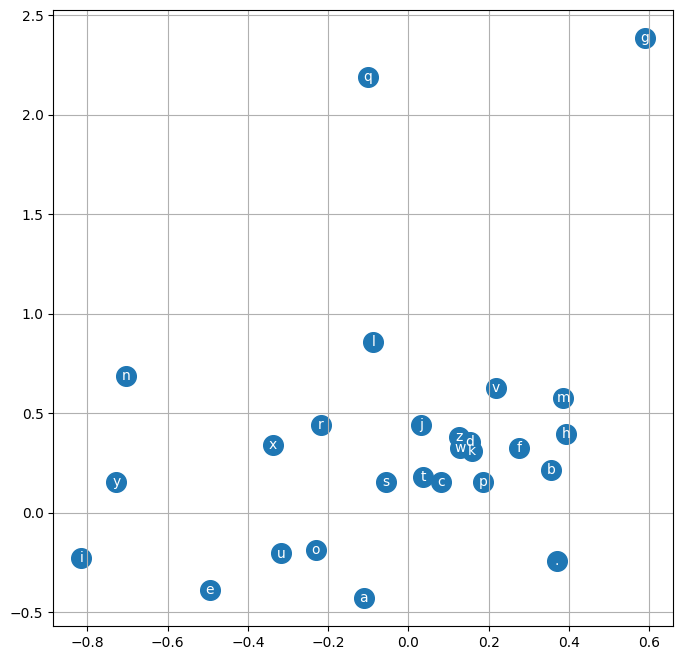

In [159]:
plt.figure(figsize = (8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itoc[i], ha="center", va="center", color='white')
plt.grid('minor')

- vowels are clustered together [acting as fillers in names]
- even y is placed near i and other vowels which is intuitive [lidian ~ lydian]
- q, g and . are special embeddings away from the rest
- they do hold meaning and NN has learnt
- but can we do better by increasing the embedding dimensions??

In [199]:
# lets try increasing the hidden layer size
feature_vector_dimensions = 20
vocab_size = len(vocab)
hidden_layer_size = 100
output_layer_size = vocab_size
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, feature_vector_dimensions), generator = g)
W1 = torch.randn((block_size*feature_vector_dimensions, hidden_layer_size), generator=g)
b1 = torch.randn(hidden_layer_size, generator = g)
W2 = torch.randn((hidden_layer_size, output_layer_size), generator = g)
b2 = torch.randn(output_layer_size, generator=g)
parameters = [C, W1, b1, W2, b2]
num_params = sum([p.nelement() for p in parameters])
for p in parameters:
    p.requires_grad = True
print(f"Num Params: {num_params}")

Num Params: 9367


In [200]:
steps = []
losses =[]

In [201]:
# learning_rate = 0.01 # 1st 50k iterations was 0.1
mini_batch_size = 32
num_iterations = 200000
for i in range(num_iterations):
    # forward pass
    # sample mini_batch
    ix = torch.randint(0, Xtr.shape[0], (mini_batch_size,))
    emb = C[Xtr[ix]] # (mini_batch_size, block_size/num input tokens, embedding_dimension)
    h = torch.tanh(emb.view(-1, 3*feature_vector_dimensions) @ W1 + b1) # z = (W1*X + b1), a = g(z) g = tanh (activation) -> dim(number_of_examples, hidden_layer_size)
    logits = h @ W2 + b2 # (hidden_layer_size, vocab_size)
    loss = F.cross_entropy(logits, ytr[ix])
    # backward pass
    # FIRST SET THE GRADS to ZERO!! In every pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update params
    learning_rate = 0.1 if i<num_iterations//2 else 0.01
    for p in parameters:
        p.data += -learning_rate*p.grad
    
    # track progress
    losses.append(loss.log10().item()) # taking log loss for scaling, better to visualize
    steps.append(i)

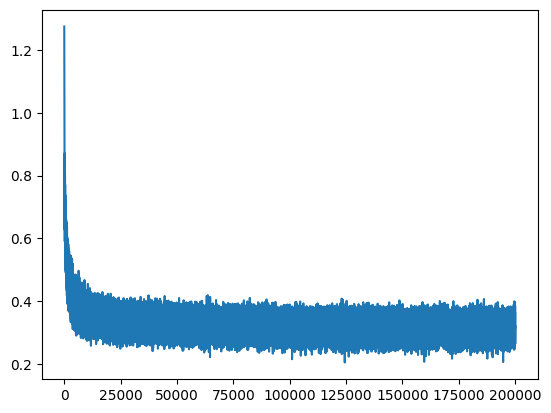

In [205]:
plt.plot(steps, losses)

- these oscillations are due to the mini_batches
- mini batch size is too small hence the noise

In [202]:
print("Training loss: ", loss.item())

Training loss:  2.298283815383911


In [203]:
# dev loss
emb = C[Xdev] # (mini_batch_size, block_size/num input tokens, embedding_dimension)
h = torch.tanh(emb.view(-1, 3*feature_vector_dimensions) @ W1 + b1) # z = (W1*X + b1), a = g(z) g = tanh (activation) -> dim(number_of_examples, hidden_layer_size)
logits = h @ W2 + b2 # (hidden_layer_size, vocab_size)
dev_loss = F.cross_entropy(logits, ydev)
print("Dev Loss: ", dev_loss.item())

Dev Loss:  2.38372802734375


- train error: 2.1
- dev loss: 2.42
- Clearly overfitting!

In [204]:
# sampling from model
g = torch.Generator().manual_seed(2147483647+10)
for _ in range(20):
    out = []
    context = [0]*block_size
    while True:
        emb = C[torch.tensor([context])] # (1,block_size, d) # since single example
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h@W2 + b2
        probs = F.softmax(logits, dim = 1) # here we need the intermediate probs for sampling and no loss calculation
        ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix==0:
            break
    print(''.join([itoc[i] for i in out]))

mona.
mayah.
seel.
nihayah.
remmastendra.
grazelynnelin.
shi.
jen.
eden.
estanaraelynn.
hoka.
cayshabersia.
mie.
tricke.
jennex.
terianubenneder.
yarul.
eha.
kayshaytnyah.
halina.


- definitely not the best names, though some minor improvements over the one layer trigram model
- few notes on parameter initialization, activations, batch normalization and gradients in part 2